In [1]:
import random
import numpy as np

import torch
import matplotlib.pyplot as plt
%matplotlib inline

from torchvision.transforms import v2 as transforms_v2
from torchvision.io import decode_image

import hydra
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose

import dr_gen.utils.data as du

%load_ext autoreload
%autoreload 2

### Setup Config & Helpers

In [2]:
root_path = "/Users/daniellerothermel/drotherm"
repo_path = f"{root_path}/repos/dr_gen/"

In [3]:
with initialize(config_path=f"../scripts/conf/", version_base=None):
    cfg = compose(
        config_name="config.yaml",
        overrides=[
            f"paths.root={root_path}",
            f"data.num_workers=4",
        ],
    )

In [4]:
print(OmegaConf.to_yaml(OmegaConf.to_container(cfg, resolve=True)))

paths:
  root: /Users/daniellerothermel/drotherm
  data: /Users/daniellerothermel/drotherm/data/dr_gen
  logs: /Users/daniellerothermel/drotherm/logs/dr_gen
  dataset_cache_root: /Users/daniellerothermel/drotherm/data/dr_gen/cifar10/
data:
  name: cifar10
  num_workers: 4
  cache_dataset: true
  download: true



In [5]:
# Following Guide for Determinism: https://pytorch.org/docs/stable/notes/randomness.html
run_seed = 100
torch.manual_seed(run_seed)
random.seed(run_seed)
np.random.seed(run_seed)
torch.use_deterministic_algorithms(True)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(run_seed)

In [6]:
# Copy helper from https://github.com/pytorch/vision/blob/main/gallery/transforms/helpers.py
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

### Test Out Dataloading

#### PIL images

In [28]:
# Test loading dataset with PIL images
cifar10_train_pil = du.get_dataset(
    cfg.data, cfg.paths, train=True, as_pil=True,
)
cifar10_train_pil

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /Users/daniellerothermel/drotherm/data/dr_gen/cifar10/
    Split: Train

In [29]:
sample_pil = cifar10_train_pil[0]
sample_pil

(<PIL.Image.Image image mode=RGB size=32x32>, 6)

In [34]:
print(f"{type(sample_pil[0]) = }")

type(sample_pil[0]) = <class 'PIL.Image.Image'>


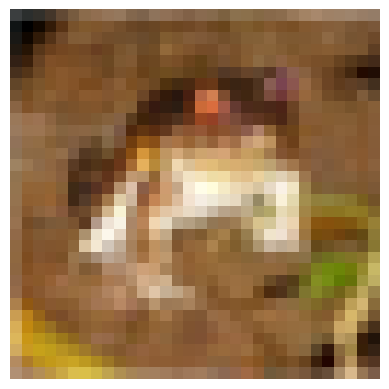

In [35]:
plt.imshow(sample_pil[0])
plt.axis("off")
plt.show()

#### TV Tensor Images

In [7]:
# Test loading dataset with tensors
cifar10_train_tvt = du.get_dataset(
    cfg.data, cfg.paths, train=True, as_pil=False,
)
cifar10_train_tvt

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /Users/daniellerothermel/drotherm/data/dr_gen/cifar10/
    Split: Train
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
                 RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
                 RandomHorizontalFlip(p=0.5)
                 ColorJitter(brightness=(0.7529411764705882, 1.2470588235294118))
                 Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201], inplace=False)
           )

In [8]:
sample_tvt = cifar10_train_tvt[0]
sample_tvt

(Image([[[-2.4291, -2.4291, -2.4291,  ..., -0.4270, -0.4612, -0.6152],
         [-2.4291, -2.4291, -2.4291,  ..., -0.3585, -0.3072, -0.2559],
         [-2.4291, -2.4291, -2.4291,  ..., -0.1874, -0.1019, -0.2216],
         ...,
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291]],
 
        [[-2.4183, -2.4183, -2.4183,  ..., -1.1336, -1.2030, -1.3245],
         [-2.4183, -2.4183, -2.4183,  ..., -1.0815, -1.0815, -1.0468],
         [-2.4183, -2.4183, -2.4183,  ..., -0.9600, -0.8905, -0.9947],
         ...,
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183]],
 
        [[-2.2214, -2.2214, -2.2214,  ..., -1.6186, -1.6530, -1.7392],
         [-2.2214, -2.2214, -2.2214,  ..., 

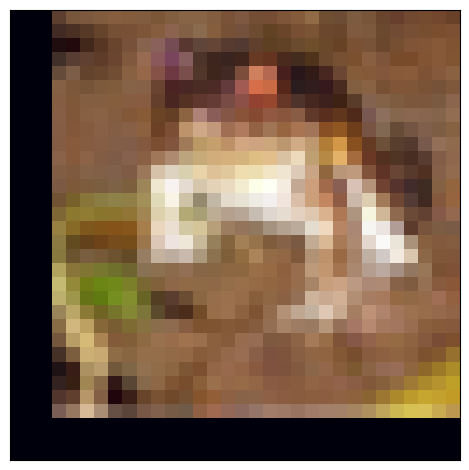

In [9]:
plot([sample_tvt[0]])

### Test out Dataloader

In [10]:
cifar10_train = du.get_dataset(
    cfg.data, cfg.paths, train=True, as_pil=False,
)

In [11]:
# Instead of using shuffle explicitly handle it via choosing samplers
dl = torch.utils.data.DataLoader(
    cifar10_train,
    batch_size=1,
    sampler=torch.utils.data.RandomSampler(cifar10_train),
    #test
    #sampler=torch.utils.data.SequentialSampler(cifar10_train),
    num_workers=cfg.data.num_workers,
    collate_fn=torch.utils.data.dataloader.default_collate,
    pin_memory=True,
    # Cannot seed workers via jlab
    #worker_init_fn=lambda wid: numpy.random.seed(torch.initial_seed() % 2**32) and random.seed(torch.initial_seed() % 2**32),
    generator=g,
)

Label: 1


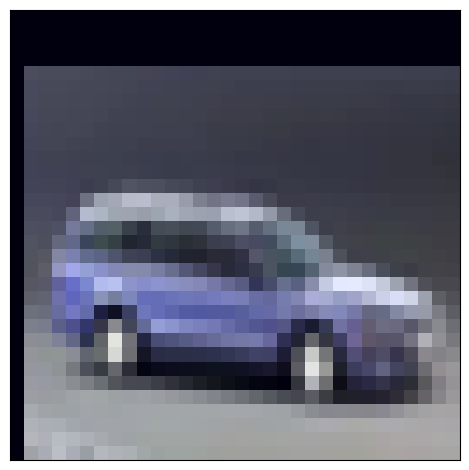

In [20]:
train_features, train_labels = next(iter(dl))
print(f"Label: {train_labels[0]}")
plot([train_features[0].squeeze()])

Label: 9


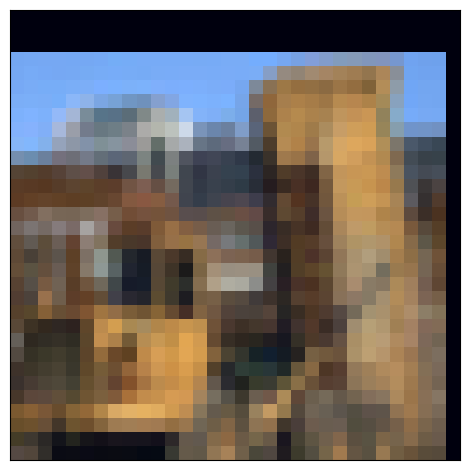

In [12]:
train_features, train_labels = next(iter(dl))
print(f"Label: {train_labels[0]}")
plot([train_features[0].squeeze()])